In [1]:
#STEP 1: generate dataset for saliency predictor


import pickle
import imp
import numpy as np
import cv2
from matplotlib import pyplot as plt

#import saliency_ds_lib
import header_saliency_ds as header 
import headoren_sal_corr_helper
import saliency_dataset
#import saliency_ds_lib
imp.reload(header)
imp.reload(headoren_sal_corr_helper)
#imp.reload(saliency_ds_lib)
imp.reload(saliency_dataset)
%matplotlib inline


fps_dict = header.fps_dict
tdict = header.topic_dict
try:
    saldat_dict
except:
    saldat_dict = {}
    
try:
    vector_ds_dict
except:
    vector_ds_dict = {}    
    
MODE = 'groundtruth'#NOTE: create saliency dataset for salnet alway use groundtruth

/home/anh2/anaconda2/envs/env_pytorch_python3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.datasets.samples_generator module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.datasets. Anything that cannot be imported from sklearn.datasets is now part of the private API.
  warnings.warn(message, FutureWarning)


In [2]:
fps_dict = header.fps_dict
tdict = header.topic_dict

salnet_datgen = saliency_dataset.SalnetDatasetGenerator_ExperimentDistance(tdict, saldat_dict, fps_dict, MODE)

LOG: initilize headoren
LOG: loading topic dict
LOG: initilize saldat dict & vector ds dict
LOG: initilize mean salmap
LOG: initilize sactivity dict


In [3]:
salnet_datgen.gen_train_dataset(0.2)

Loading saliency maps for ds: 1 topic: paris at ../hmd-observe-video-prediction/data/pano-saliency-merge/saliency_distance_ds1_topicparis
Loading saliency maps for ds: 1 topic: roller at ../hmd-observe-video-prediction/data/pano-saliency-merge/saliency_distance_ds1_topicroller
Loading saliency maps for ds: 1 topic: venise at ../hmd-observe-video-prediction/data/pano-saliency-merge/saliency_distance_ds1_topicvenise
Loading saliency maps for ds: 1 topic: diving at ../hmd-observe-video-prediction/data/pano-saliency-merge/saliency_distance_ds1_topicdiving
Loading saliency maps for ds: 1 topic: timelapse at ../hmd-observe-video-prediction/data/pano-saliency-merge/saliency_distance_ds1_topictimelapse
Loading saliency maps for ds: 2 topic: 0 at ../hmd-observe-video-prediction/data/pano-saliency-merge/saliency_distance_ds2_topic0
Loading saliency maps for ds: 2 topic: 1 at ../hmd-observe-video-prediction/data/pano-saliency-merge/saliency_distance_ds2_topic1
Loading saliency maps for ds: 2 topi

In [4]:
salnet_datgen.gen_test_dataset()

In [5]:
salnet_datgen.gen_whole_dataset()

Error at :1 - paris - 60.10000000000005 - [Errno 2] No such file or directory: './data/pano-videos/frames/paris_3602.jpg'
60.88000000000005 998 60.88000000000005 60.82000000000005
Error at :1 - roller - 60.88000000000005 - No active exception to reraise
60.88000000000005 998 60.88000000000005 60.82000000000005
Error at :1 - venise - 60.88000000000005 - No active exception to reraise
59.92000000000005 982 59.92000000000005 59.86000000000005
Error at :1 - diving - 59.92000000000005 - No active exception to reraise
60.88000000000005 998 60.88000000000005 60.82000000000005
Error at :1 - timelapse - 60.88000000000005 - No active exception to reraise
60.88000000000005 998 60.88000000000005 60.82000000000005
Error at :2 - 0 - 60.88000000000005 - No active exception to reraise
60.88000000000005 998 60.88000000000005 60.82000000000005
Error at :2 - 1 - 60.88000000000005 - No active exception to reraise
60.88000000000005 998 60.88000000000005 60.82000000000005
Error at :2 - 2 - 60.88000000000005

In [17]:
#DEBUG for class pakage
ds = 3
topic = 'sport'
t0 = 18.66
img, smap = salnet_datgen.get_sample(ds, topic, t0)
plt.imshow(img)
plt.figure()
plt.imshow(smap, cmap='gray')

NameError: name 'salnet_datgen' is not defined

In [21]:
#STEP2: train saliency predictor
import numpy as np
import pickle
import cv2
import imp

import torch as t
import torchvision as tv
import torchvision.transforms as transform
#from torch.utils.data import Dataset, DataLoader

import saliency_predictor
import header_headoren_salcorr as header
import header_saliency_ds as header_sal
imp.reload(header_sal)
imp.reload(header)

from matplotlib import pyplot as plt
%matplotlib inline

use_cuda = t.cuda.is_available()
device = t.device("cuda:0" if use_cuda else "cpu")
BATCH_SIZE = header_sal.BATCH_SIZE

class AddGaussianNoise(object):
    def __init__(self, mean=0., std=1., p=0.5):
        self.std = std
        self.mean = mean
        self.p = p
        
    def __call__(self, tensor):
        if np.random.rand() > self.p:
            return tensor
        return tensor + t.randn(tensor.size()) * self.std + self.mean
    
    def __repr__(self):
        return self.__class__.__name__ + '(mean={0}, std={1})'.format(self.mean, self.std)


In [22]:
resnet = tv.models.resnet101(pretrained=True)
saliency_predictor.modify_fc_layers(resnet)
resnet.to(device)
PATH = '../hmd-observe-video-prediction/models/panoresnet101_sal45x80merged_step002_expdistance_150'
resnet.load_state_dict(t.load(PATH, map_location=device))

<All keys matched successfully>

In [23]:
sal_ds_filepath = '../hmd-observe-video-prediction/data/pano-saliency-merge/ds_dcnn_expdistance_step0.2'
#sal_ds_filepath = '../hmd-observe-video-prediction/data/pano-saliency-merge/ds_dcnn_expdistance_full'
#sal_ds_filepath = './dataset/pano-saliency/ds_full'
tf5 =  transform.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
#tv.transforms.ColorJitter(brightness=0.3, contrast=0.2, saturation=0.2, hue=0.1)
transform_train = [tv.transforms.ToTensor(), tf5]
transform_test  = [tv.transforms.ToTensor(), tf5]
transform_gen   = [tv.transforms.ToTensor(), tf5]
transformed_dataset = saliency_predictor.PanoSalDataset(sal_ds_filepath, transform=tv.transforms.Compose(transform_train))
trainloader = t.utils.data.DataLoader(transformed_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

In [24]:
learning_rate = 3e-4
optim = t.optim.Adam(resnet.parameters(), lr=learning_rate)
loss_log = []

In [25]:
import timeit

N_EPOCH = 301
N_REPORT = 200


btime = timeit.default_timer()
for epoch in range(N_EPOCH):
    running_loss = 0.
    for i, (t0, img_list, label_list) in enumerate(trainloader):
        start = t.cuda.Event(enable_timing=True)
        end = t.cuda.Event(enable_timing=True)
        #start.record() ###measure training time for one iteration
        img_list = img_list.type(t.FloatTensor).to(device)
        label_list = label_list.type(t.FloatTensor).to(device)
        optim.zero_grad()
        fx = resnet(img_list)
        #print (fx.shape)
        fx = fx.view(-1, header_sal.TARGET_SAL_H, header_sal.TARGET_SAL_W)
        #loss = t.nn.functional.mse_loss(fx, label_list)
        loss = t.norm(fx - label_list, 2)
        loss.backward()#now backward, grad in graph will have something
        optim.step()#now, the weights is update.
        
        running_loss += loss.item()
        if i % N_REPORT == N_REPORT-1:    # print every N_REPORT mini-batches
            #end.record()
            #t.cuda.synchronize()
            
            print ('exec time: {}, cur learning rate: {}'.format(timeit.default_timer() - btime, saliency_predictor.get_lr(optim)))
            btime = timeit.default_timer()
            print('[%d, %5d] loss: %.3f' %
                  (epoch + 1, i + 1, running_loss / N_REPORT))
            loss_log.append(running_loss/N_REPORT)
            running_loss = 0.0
            
            
    #eval_accuracy(yolo, pred, testloader, device, threshold=0.5)
    if epoch % 30 ==0 and epoch > 1:
                t.save(resnet.state_dict(), '../hmd-observe-video-prediction/models/panoresnet101_sal45x80merged_step002_expdistance_{}'.format(epoch))
                #eval_accuracy(yolo, pred, testloader, device, threshold=0.5)

exec time: 17.00534498412162, cur learning rate: 0.0003
[1,   200] loss: 1.055
exec time: 16.404892162419856, cur learning rate: 0.0003
[1,   400] loss: 1.024
exec time: 16.397745520807803, cur learning rate: 0.0003
[1,   600] loss: 1.091
exec time: 16.486790486611426, cur learning rate: 0.0003
[1,   800] loss: 1.063
exec time: 16.506492781452835, cur learning rate: 0.0003
[1,  1000] loss: 1.031
exec time: 16.350295268930495, cur learning rate: 0.0003
[1,  1200] loss: 1.146
exec time: 16.47682650387287, cur learning rate: 0.0003
[1,  1400] loss: 1.078
exec time: 16.394584922119975, cur learning rate: 0.0003
[1,  1600] loss: 1.051
exec time: 17.778604097664356, cur learning rate: 0.0003
[2,   200] loss: 1.067
exec time: 16.35678100772202, cur learning rate: 0.0003
[2,   400] loss: 1.084
exec time: 16.375171677209437, cur learning rate: 0.0003
[2,   600] loss: 1.034
exec time: 16.379939704202116, cur learning rate: 0.0003
[2,   800] loss: 1.096
exec time: 16.359938818961382, cur learning

exec time: 16.514613166451454, cur learning rate: 0.0003
[13,  1600] loss: 1.000
exec time: 17.739452593959868, cur learning rate: 0.0003
[14,   200] loss: 1.022
exec time: 16.240962726064026, cur learning rate: 0.0003
[14,   400] loss: 1.011
exec time: 16.497918856330216, cur learning rate: 0.0003
[14,   600] loss: 1.006
exec time: 16.565182831138372, cur learning rate: 0.0003
[14,   800] loss: 1.021
exec time: 16.534590765833855, cur learning rate: 0.0003
[14,  1000] loss: 1.027
exec time: 16.635174089111388, cur learning rate: 0.0003
[14,  1200] loss: 1.072
exec time: 16.515858264639974, cur learning rate: 0.0003
[14,  1400] loss: 1.009
exec time: 16.597928492352366, cur learning rate: 0.0003
[14,  1600] loss: 1.050
exec time: 18.30837736558169, cur learning rate: 0.0003
[15,   200] loss: 0.998
exec time: 16.8438123408705, cur learning rate: 0.0003
[15,   400] loss: 1.097
exec time: 16.226259745657444, cur learning rate: 0.0003
[15,   600] loss: 1.017
exec time: 16.31421026866883, c

exec time: 16.646184637211263, cur learning rate: 0.0003
[26,  1200] loss: 1.004
exec time: 15.481705752201378, cur learning rate: 0.0003
[26,  1400] loss: 1.036
exec time: 15.364863559603691, cur learning rate: 0.0003
[26,  1600] loss: 1.004
exec time: 16.745985470712185, cur learning rate: 0.0003
[27,   200] loss: 0.981
exec time: 15.362523319199681, cur learning rate: 0.0003
[27,   400] loss: 0.985
exec time: 15.338989687152207, cur learning rate: 0.0003
[27,   600] loss: 0.951
exec time: 15.352501539513469, cur learning rate: 0.0003
[27,   800] loss: 0.993
exec time: 15.465534447692335, cur learning rate: 0.0003
[27,  1000] loss: 1.001
exec time: 17.029459834098816, cur learning rate: 0.0003
[27,  1200] loss: 1.019
exec time: 17.009540248662233, cur learning rate: 0.0003
[27,  1400] loss: 1.058
exec time: 16.95975871849805, cur learning rate: 0.0003
[27,  1600] loss: 0.969
exec time: 18.53955783136189, cur learning rate: 0.0003
[28,   200] loss: 0.984
exec time: 17.021567506715655,

exec time: 16.796110161580145, cur learning rate: 0.0003
[39,   800] loss: 1.007
exec time: 16.775466227903962, cur learning rate: 0.0003
[39,  1000] loss: 1.022
exec time: 16.700664236210287, cur learning rate: 0.0003
[39,  1200] loss: 0.954
exec time: 16.799294064752758, cur learning rate: 0.0003
[39,  1400] loss: 1.005
exec time: 16.792234457097948, cur learning rate: 0.0003
[39,  1600] loss: 0.974
exec time: 17.99135269317776, cur learning rate: 0.0003
[40,   200] loss: 0.960
exec time: 16.713153455406427, cur learning rate: 0.0003
[40,   400] loss: 0.959
exec time: 16.398784124292433, cur learning rate: 0.0003
[40,   600] loss: 1.005
exec time: 16.445779184810817, cur learning rate: 0.0003
[40,   800] loss: 0.988
exec time: 16.537226133979857, cur learning rate: 0.0003
[40,  1000] loss: 0.980
exec time: 16.5917461309582, cur learning rate: 0.0003
[40,  1200] loss: 0.974
exec time: 16.54810231178999, cur learning rate: 0.0003
[40,  1400] loss: 1.038
exec time: 16.594848964363337, c

exec time: 15.363104675896466, cur learning rate: 0.0003
[52,   400] loss: 0.947
exec time: 15.360920292325318, cur learning rate: 0.0003
[52,   600] loss: 0.940
exec time: 15.371221753768623, cur learning rate: 0.0003
[52,   800] loss: 0.957
exec time: 15.351419465616345, cur learning rate: 0.0003
[52,  1000] loss: 0.950
exec time: 15.36425415892154, cur learning rate: 0.0003
[52,  1200] loss: 0.927
exec time: 15.360172143206, cur learning rate: 0.0003
[52,  1400] loss: 0.977
exec time: 15.383942641317844, cur learning rate: 0.0003
[52,  1600] loss: 0.931
exec time: 17.548602296970785, cur learning rate: 0.0003
[53,   200] loss: 0.951
exec time: 16.44699020124972, cur learning rate: 0.0003
[53,   400] loss: 0.984
exec time: 16.34357020072639, cur learning rate: 0.0003
[53,   600] loss: 0.980
exec time: 16.358490430749953, cur learning rate: 0.0003
[53,   800] loss: 0.932
exec time: 16.542601101100445, cur learning rate: 0.0003
[53,  1000] loss: 0.949
exec time: 16.89346980024129, cur 

exec time: 16.494739334098995, cur learning rate: 0.0003
[64,  1600] loss: 0.935
exec time: 17.78630707692355, cur learning rate: 0.0003
[65,   200] loss: 0.928
exec time: 16.662188892252743, cur learning rate: 0.0003
[65,   400] loss: 0.938
exec time: 16.5385552784428, cur learning rate: 0.0003
[65,   600] loss: 0.934
exec time: 16.437749098986387, cur learning rate: 0.0003
[65,   800] loss: 0.985
exec time: 16.515939716249704, cur learning rate: 0.0003
[65,  1000] loss: 0.935
exec time: 16.43544407747686, cur learning rate: 0.0003
[65,  1200] loss: 0.958
exec time: 16.428096576593816, cur learning rate: 0.0003
[65,  1400] loss: 0.927
exec time: 16.42865968775004, cur learning rate: 0.0003
[65,  1600] loss: 0.890
exec time: 17.803391369059682, cur learning rate: 0.0003
[66,   200] loss: 0.873
exec time: 16.47757044993341, cur learning rate: 0.0003
[66,   400] loss: 0.942
exec time: 16.539452630095184, cur learning rate: 0.0003
[66,   600] loss: 0.947
exec time: 16.512559653259814, cur

exec time: 17.155987072736025, cur learning rate: 0.0003
[77,  1200] loss: 0.872
exec time: 16.387044543400407, cur learning rate: 0.0003
[77,  1400] loss: 0.905
exec time: 16.346850093454123, cur learning rate: 0.0003
[77,  1600] loss: 0.938
exec time: 17.83385396376252, cur learning rate: 0.0003
[78,   200] loss: 0.889
exec time: 16.354959454387426, cur learning rate: 0.0003
[78,   400] loss: 0.973
exec time: 16.27741200942546, cur learning rate: 0.0003
[78,   600] loss: 0.876
exec time: 16.282665053382516, cur learning rate: 0.0003
[78,   800] loss: 0.890
exec time: 16.338521832600236, cur learning rate: 0.0003
[78,  1000] loss: 0.922
exec time: 16.260032285004854, cur learning rate: 0.0003
[78,  1200] loss: 0.924
exec time: 16.290355302393436, cur learning rate: 0.0003
[78,  1400] loss: 0.919
exec time: 16.31722471769899, cur learning rate: 0.0003
[78,  1600] loss: 0.904
exec time: 17.743193321861327, cur learning rate: 0.0003
[79,   200] loss: 0.914
exec time: 16.302630667574704, 

exec time: 16.32055228948593, cur learning rate: 0.0003
[90,   800] loss: 0.926
exec time: 16.348683116026223, cur learning rate: 0.0003
[90,  1000] loss: 0.870
exec time: 16.51412818301469, cur learning rate: 0.0003
[90,  1200] loss: 0.892
exec time: 16.584587967954576, cur learning rate: 0.0003
[90,  1400] loss: 0.951
exec time: 16.610402576625347, cur learning rate: 0.0003
[90,  1600] loss: 0.940
exec time: 18.075675401836634, cur learning rate: 0.0003
[91,   200] loss: 0.859
exec time: 16.517062610946596, cur learning rate: 0.0003
[91,   400] loss: 0.880
exec time: 16.73236618936062, cur learning rate: 0.0003
[91,   600] loss: 0.830
exec time: 16.348740662448108, cur learning rate: 0.0003
[91,   800] loss: 0.859
exec time: 16.365586049854755, cur learning rate: 0.0003
[91,  1000] loss: 0.889
exec time: 16.294432780705392, cur learning rate: 0.0003
[91,  1200] loss: 0.891
exec time: 16.391149303875864, cur learning rate: 0.0003
[91,  1400] loss: 0.893
exec time: 16.54114198870957, c

exec time: 16.529093329794705, cur learning rate: 0.0003
[103,   400] loss: 0.826
exec time: 16.472416740842164, cur learning rate: 0.0003
[103,   600] loss: 0.907
exec time: 16.52845898270607, cur learning rate: 0.0003
[103,   800] loss: 0.840
exec time: 16.39031882211566, cur learning rate: 0.0003
[103,  1000] loss: 0.889
exec time: 16.4009632980451, cur learning rate: 0.0003
[103,  1200] loss: 0.900
exec time: 16.52980215102434, cur learning rate: 0.0003
[103,  1400] loss: 0.912
exec time: 16.368843489326537, cur learning rate: 0.0003
[103,  1600] loss: 0.869
exec time: 17.755027951672673, cur learning rate: 0.0003
[104,   200] loss: 0.881
exec time: 16.35594473220408, cur learning rate: 0.0003
[104,   400] loss: 0.882
exec time: 16.33124967198819, cur learning rate: 0.0003
[104,   600] loss: 0.904
exec time: 16.478169959038496, cur learning rate: 0.0003
[104,   800] loss: 0.884
exec time: 16.319385077804327, cur learning rate: 0.0003
[104,  1000] loss: 0.878
exec time: 16.485685290

exec time: 16.70648681651801, cur learning rate: 0.0003
[115,  1400] loss: 0.908
exec time: 17.03685448039323, cur learning rate: 0.0003
[115,  1600] loss: 0.872
exec time: 18.18731712549925, cur learning rate: 0.0003
[116,   200] loss: 0.827
exec time: 16.728644696995616, cur learning rate: 0.0003
[116,   400] loss: 0.840
exec time: 16.803453993983567, cur learning rate: 0.0003
[116,   600] loss: 0.840
exec time: 16.79078916553408, cur learning rate: 0.0003
[116,   800] loss: 0.895
exec time: 16.759796855039895, cur learning rate: 0.0003
[116,  1000] loss: 0.890
exec time: 16.78124889265746, cur learning rate: 0.0003
[116,  1200] loss: 0.838
exec time: 16.867171866819263, cur learning rate: 0.0003
[116,  1400] loss: 0.889
exec time: 16.847072549164295, cur learning rate: 0.0003
[116,  1600] loss: 0.851
exec time: 18.399479914456606, cur learning rate: 0.0003
[117,   200] loss: 0.823
exec time: 16.806854921393096, cur learning rate: 0.0003
[117,   400] loss: 0.839
exec time: 16.4327392

exec time: 16.368925978429615, cur learning rate: 0.0003
[128,   800] loss: 0.876
exec time: 16.51495988573879, cur learning rate: 0.0003
[128,  1000] loss: 0.849
exec time: 16.431688860058784, cur learning rate: 0.0003
[128,  1200] loss: 0.881
exec time: 16.53585227765143, cur learning rate: 0.0003
[128,  1400] loss: 0.941
exec time: 16.430282521992922, cur learning rate: 0.0003
[128,  1600] loss: 0.834
exec time: 17.989837946370244, cur learning rate: 0.0003
[129,   200] loss: 0.857
exec time: 16.683925447054207, cur learning rate: 0.0003
[129,   400] loss: 0.813
exec time: 16.602043569087982, cur learning rate: 0.0003
[129,   600] loss: 0.865
exec time: 16.705467429943383, cur learning rate: 0.0003
[129,   800] loss: 0.893
exec time: 16.435371235013008, cur learning rate: 0.0003
[129,  1000] loss: 0.863
exec time: 16.568300344981253, cur learning rate: 0.0003
[129,  1200] loss: 0.862
exec time: 16.330327196978033, cur learning rate: 0.0003
[129,  1400] loss: 0.849
exec time: 16.4358

exec time: 17.790177668444812, cur learning rate: 0.0003
[141,   200] loss: 0.847
exec time: 16.30114298220724, cur learning rate: 0.0003
[141,   400] loss: 0.859
exec time: 16.383877300657332, cur learning rate: 0.0003
[141,   600] loss: 0.854
exec time: 16.386670702137053, cur learning rate: 0.0003
[141,   800] loss: 0.921
exec time: 16.69762504287064, cur learning rate: 0.0003
[141,  1000] loss: 0.886
exec time: 16.46426358819008, cur learning rate: 0.0003
[141,  1200] loss: 0.846
exec time: 16.520908982492983, cur learning rate: 0.0003
[141,  1400] loss: 0.819
exec time: 16.536341602914035, cur learning rate: 0.0003
[141,  1600] loss: 0.836
exec time: 17.90063937753439, cur learning rate: 0.0003
[142,   200] loss: 0.880
exec time: 16.37910997029394, cur learning rate: 0.0003
[142,   400] loss: 0.876
exec time: 16.408628980629146, cur learning rate: 0.0003
[142,   600] loss: 0.835
exec time: 16.49798239208758, cur learning rate: 0.0003
[142,   800] loss: 0.838
exec time: 16.35672005

exec time: 16.394996422342956, cur learning rate: 0.0003
[153,  1200] loss: 0.833
exec time: 16.407153429463506, cur learning rate: 0.0003
[153,  1400] loss: 0.860
exec time: 16.528284903615713, cur learning rate: 0.0003
[153,  1600] loss: 0.855
exec time: 17.74124154355377, cur learning rate: 0.0003
[154,   200] loss: 0.807
exec time: 16.310696525499225, cur learning rate: 0.0003
[154,   400] loss: 0.827
exec time: 16.35954883787781, cur learning rate: 0.0003
[154,   600] loss: 0.831
exec time: 16.360852010548115, cur learning rate: 0.0003
[154,   800] loss: 0.876
exec time: 16.908406142145395, cur learning rate: 0.0003
[154,  1000] loss: 0.866
exec time: 16.25946082174778, cur learning rate: 0.0003
[154,  1200] loss: 0.824
exec time: 16.220464212819934, cur learning rate: 0.0003
[154,  1400] loss: 0.852
exec time: 16.22849692031741, cur learning rate: 0.0003
[154,  1600] loss: 0.822
exec time: 18.56135913077742, cur learning rate: 0.0003
[155,   200] loss: 0.818
exec time: 16.8237964

exec time: 16.61963395960629, cur learning rate: 0.0003
[166,   600] loss: 0.900
exec time: 16.568702683784068, cur learning rate: 0.0003
[166,   800] loss: 0.812
exec time: 16.663267319090664, cur learning rate: 0.0003
[166,  1000] loss: 0.812
exec time: 16.349981560371816, cur learning rate: 0.0003
[166,  1200] loss: 0.760
exec time: 16.324089754372835, cur learning rate: 0.0003
[166,  1400] loss: 0.806
exec time: 16.3062050845474, cur learning rate: 0.0003
[166,  1600] loss: 0.834
exec time: 17.759656709618866, cur learning rate: 0.0003
[167,   200] loss: 0.778
exec time: 16.547158964909613, cur learning rate: 0.0003
[167,   400] loss: 0.808
exec time: 16.420521104708314, cur learning rate: 0.0003
[167,   600] loss: 0.825
exec time: 16.451704072766006, cur learning rate: 0.0003
[167,   800] loss: 0.825
exec time: 16.355209187604487, cur learning rate: 0.0003
[167,  1000] loss: 0.819
exec time: 16.403487905859947, cur learning rate: 0.0003
[167,  1200] loss: 0.812
exec time: 16.35351

exec time: 16.203034108504653, cur learning rate: 0.0003
[178,  1600] loss: 0.818
exec time: 16.69601161684841, cur learning rate: 0.0003
[179,   200] loss: 0.892
exec time: 15.334759326651692, cur learning rate: 0.0003
[179,   400] loss: 0.861
exec time: 15.334137412719429, cur learning rate: 0.0003
[179,   600] loss: 0.837
exec time: 15.341537540778518, cur learning rate: 0.0003
[179,   800] loss: 0.839
exec time: 15.343078128062189, cur learning rate: 0.0003
[179,  1000] loss: 0.831
exec time: 15.348238716833293, cur learning rate: 0.0003
[179,  1200] loss: 0.867
exec time: 15.584901791065931, cur learning rate: 0.0003
[179,  1400] loss: 0.816
exec time: 16.141638208180666, cur learning rate: 0.0003
[179,  1600] loss: 0.791
exec time: 17.854129939340055, cur learning rate: 0.0003
[180,   200] loss: 0.807
exec time: 16.33962234482169, cur learning rate: 0.0003
[180,   400] loss: 0.850
exec time: 16.352966339327395, cur learning rate: 0.0003
[180,   600] loss: 0.963
exec time: 16.7121

exec time: 16.491436601616442, cur learning rate: 0.0003
[191,  1000] loss: 0.881
exec time: 16.54362830426544, cur learning rate: 0.0003
[191,  1200] loss: 0.896
exec time: 16.475773375481367, cur learning rate: 0.0003
[191,  1400] loss: 0.845
exec time: 16.399985273368657, cur learning rate: 0.0003
[191,  1600] loss: 0.799
exec time: 17.836040400899947, cur learning rate: 0.0003
[192,   200] loss: 0.780
exec time: 16.38694386743009, cur learning rate: 0.0003
[192,   400] loss: 0.798
exec time: 16.34892888739705, cur learning rate: 0.0003
[192,   600] loss: 0.829
exec time: 16.374186117202044, cur learning rate: 0.0003
[192,   800] loss: 0.866
exec time: 15.645643726922572, cur learning rate: 0.0003
[192,  1000] loss: 0.801
exec time: 15.386059091426432, cur learning rate: 0.0003
[192,  1200] loss: 0.888
exec time: 15.407386844977736, cur learning rate: 0.0003
[192,  1400] loss: 0.924
exec time: 15.415598229505122, cur learning rate: 0.0003
[192,  1600] loss: 0.798
exec time: 16.72985

exec time: 16.62691188417375, cur learning rate: 0.0003
[204,   400] loss: 0.781
exec time: 17.026945075020194, cur learning rate: 0.0003
[204,   600] loss: 0.767
exec time: 17.041507378220558, cur learning rate: 0.0003
[204,   800] loss: 0.825
exec time: 16.71860575862229, cur learning rate: 0.0003
[204,  1000] loss: 0.775
exec time: 16.229724552482367, cur learning rate: 0.0003
[204,  1200] loss: 0.834
exec time: 16.829085014760494, cur learning rate: 0.0003
[204,  1400] loss: 0.820
exec time: 16.9874748615548, cur learning rate: 0.0003
[204,  1600] loss: 0.802
exec time: 18.468442706391215, cur learning rate: 0.0003
[205,   200] loss: 0.782
exec time: 16.916144686751068, cur learning rate: 0.0003
[205,   400] loss: 0.833
exec time: 16.77786509785801, cur learning rate: 0.0003
[205,   600] loss: 0.775
exec time: 16.439783305861056, cur learning rate: 0.0003
[205,   800] loss: 0.832
exec time: 16.526380291208625, cur learning rate: 0.0003
[205,  1000] loss: 0.821
exec time: 16.6990492

exec time: 17.052221345715225, cur learning rate: 0.0003
[216,  1400] loss: 0.835
exec time: 17.097145594656467, cur learning rate: 0.0003
[216,  1600] loss: 0.824
exec time: 17.853135981597006, cur learning rate: 0.0003
[217,   200] loss: 0.737
exec time: 16.383215812966228, cur learning rate: 0.0003
[217,   400] loss: 0.744
exec time: 16.287067271769047, cur learning rate: 0.0003
[217,   600] loss: 0.804
exec time: 16.24262276198715, cur learning rate: 0.0003
[217,   800] loss: 0.767
exec time: 16.259289727546275, cur learning rate: 0.0003
[217,  1000] loss: 0.778
exec time: 16.317748957313597, cur learning rate: 0.0003
[217,  1200] loss: 0.777
exec time: 16.455932249315083, cur learning rate: 0.0003
[217,  1400] loss: 0.756
exec time: 16.325081589631736, cur learning rate: 0.0003
[217,  1600] loss: 0.806
exec time: 18.020829332061112, cur learning rate: 0.0003
[218,   200] loss: 0.755
exec time: 16.98661561589688, cur learning rate: 0.0003
[218,   400] loss: 0.770
exec time: 17.0132

exec time: 17.173666304908693, cur learning rate: 0.0003
[229,   800] loss: 0.882
exec time: 17.18806358613074, cur learning rate: 0.0003
[229,  1000] loss: 0.867
exec time: 17.141347120516002, cur learning rate: 0.0003
[229,  1200] loss: 0.859
exec time: 17.16454798448831, cur learning rate: 0.0003
[229,  1400] loss: 0.814
exec time: 17.23571872431785, cur learning rate: 0.0003
[229,  1600] loss: 0.809
exec time: 18.218292083591223, cur learning rate: 0.0003
[230,   200] loss: 0.818
exec time: 16.915893273428082, cur learning rate: 0.0003
[230,   400] loss: 0.818
exec time: 16.72975855693221, cur learning rate: 0.0003
[230,   600] loss: 0.826
exec time: 16.343928060494363, cur learning rate: 0.0003
[230,   800] loss: 0.790
exec time: 16.322751658968627, cur learning rate: 0.0003
[230,  1000] loss: 0.793
exec time: 16.32830800116062, cur learning rate: 0.0003
[230,  1200] loss: 0.759
exec time: 16.30740767158568, cur learning rate: 0.0003
[230,  1400] loss: 0.828
exec time: 16.36646037

exec time: 18.08958302345127, cur learning rate: 0.0003
[242,   200] loss: 0.752
exec time: 16.25952032674104, cur learning rate: 0.0003
[242,   400] loss: 0.836
exec time: 16.29938576091081, cur learning rate: 0.0003
[242,   600] loss: 0.747
exec time: 16.216579739004374, cur learning rate: 0.0003
[242,   800] loss: 0.770
exec time: 16.124343399889767, cur learning rate: 0.0003
[242,  1000] loss: 0.786
exec time: 16.36631539836526, cur learning rate: 0.0003
[242,  1200] loss: 0.821
exec time: 16.417722184211016, cur learning rate: 0.0003
[242,  1400] loss: 0.815
exec time: 16.555891719646752, cur learning rate: 0.0003
[242,  1600] loss: 0.828
exec time: 18.026569021865726, cur learning rate: 0.0003
[243,   200] loss: 0.794
exec time: 16.164875167421997, cur learning rate: 0.0003
[243,   400] loss: 0.760
exec time: 15.353715137578547, cur learning rate: 0.0003
[243,   600] loss: 1.188
exec time: 15.343265227973461, cur learning rate: 0.0003
[243,   800] loss: 1.209
exec time: 15.350689

exec time: 15.348428183235228, cur learning rate: 0.0003
[254,  1200] loss: 0.771
exec time: 15.351385708898306, cur learning rate: 0.0003
[254,  1400] loss: 0.778
exec time: 15.346559261903167, cur learning rate: 0.0003
[254,  1600] loss: 0.790
exec time: 16.769419354386628, cur learning rate: 0.0003
[255,   200] loss: 0.744
exec time: 16.6312497286126, cur learning rate: 0.0003
[255,   400] loss: 0.726
exec time: 16.59572244528681, cur learning rate: 0.0003
[255,   600] loss: 0.786
exec time: 16.42899957485497, cur learning rate: 0.0003
[255,   800] loss: 0.759
exec time: 16.583824290893972, cur learning rate: 0.0003
[255,  1000] loss: 0.780
exec time: 16.424778095446527, cur learning rate: 0.0003
[255,  1200] loss: 0.713
exec time: 16.46692772395909, cur learning rate: 0.0003
[255,  1400] loss: 0.808
exec time: 16.72694084327668, cur learning rate: 0.0003
[255,  1600] loss: 0.799
exec time: 18.204998501576483, cur learning rate: 0.0003
[256,   200] loss: 0.787
exec time: 16.78704451

exec time: 15.343133893795311, cur learning rate: 0.0003
[267,   600] loss: 0.732
exec time: 15.967780414968729, cur learning rate: 0.0003
[267,   800] loss: 0.771
exec time: 16.1367765981704, cur learning rate: 0.0003
[267,  1000] loss: 0.810
exec time: 16.23785464372486, cur learning rate: 0.0003
[267,  1200] loss: 0.766
exec time: 16.071261348202825, cur learning rate: 0.0003
[267,  1400] loss: 0.762
exec time: 16.186611514538527, cur learning rate: 0.0003
[267,  1600] loss: 0.722
exec time: 17.804473534226418, cur learning rate: 0.0003
[268,   200] loss: 0.738
exec time: 16.332858715206385, cur learning rate: 0.0003
[268,   400] loss: 0.729
exec time: 16.307572080753744, cur learning rate: 0.0003
[268,   600] loss: 0.755
exec time: 16.228298182599247, cur learning rate: 0.0003
[268,   800] loss: 0.765
exec time: 15.348255947232246, cur learning rate: 0.0003
[268,  1000] loss: 0.741
exec time: 15.3572415439412, cur learning rate: 0.0003
[268,  1200] loss: 0.737
exec time: 15.3504137

exec time: 15.341323067434132, cur learning rate: 0.0003
[279,  1600] loss: 0.756
exec time: 16.71706774737686, cur learning rate: 0.0003
[280,   200] loss: 0.725
exec time: 15.347213907167315, cur learning rate: 0.0003
[280,   400] loss: 0.748
exec time: 15.358178314752877, cur learning rate: 0.0003
[280,   600] loss: 0.709
exec time: 15.343462811782956, cur learning rate: 0.0003
[280,   800] loss: 0.736
exec time: 15.327850070782006, cur learning rate: 0.0003
[280,  1000] loss: 0.759
exec time: 15.995536003261805, cur learning rate: 0.0003
[280,  1200] loss: 0.753
exec time: 16.518494049087167, cur learning rate: 0.0003
[280,  1400] loss: 0.738
exec time: 16.38653180282563, cur learning rate: 0.0003
[280,  1600] loss: 0.767
exec time: 17.991033473052084, cur learning rate: 0.0003
[281,   200] loss: 0.754
exec time: 16.499355181120336, cur learning rate: 0.0003
[281,   400] loss: 0.740
exec time: 16.515114663168788, cur learning rate: 0.0003
[281,   600] loss: 0.739
exec time: 16.5040

exec time: 16.434605421498418, cur learning rate: 0.0003
[292,  1000] loss: 0.779
exec time: 16.406726324930787, cur learning rate: 0.0003
[292,  1200] loss: 0.780
exec time: 16.41558149456978, cur learning rate: 0.0003
[292,  1400] loss: 0.748
exec time: 16.372869403101504, cur learning rate: 0.0003
[292,  1600] loss: 0.807
exec time: 17.825783484615386, cur learning rate: 0.0003
[293,   200] loss: 0.779
exec time: 16.48922205157578, cur learning rate: 0.0003
[293,   400] loss: 0.768
exec time: 16.435186523012817, cur learning rate: 0.0003
[293,   600] loss: 0.763
exec time: 16.535094620659947, cur learning rate: 0.0003
[293,   800] loss: 0.720
exec time: 16.303732154890895, cur learning rate: 0.0003
[293,  1000] loss: 0.787
exec time: 16.35149900522083, cur learning rate: 0.0003
[293,  1200] loss: 0.746
exec time: 16.34490094333887, cur learning rate: 0.0003
[293,  1400] loss: 0.722
exec time: 16.444758230820298, cur learning rate: 0.0003
[293,  1600] loss: 0.751
exec time: 17.771153

In [ ]:
#t.save(resnet.state_dict(), '../hmd-observe-video-prediction/models/panoresnet101_sal45x80merged_step002_expdistance_{}'.format(epoch))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


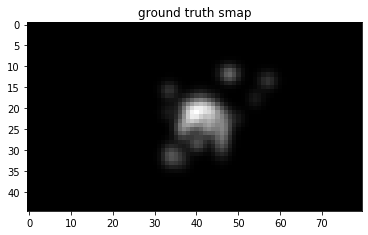

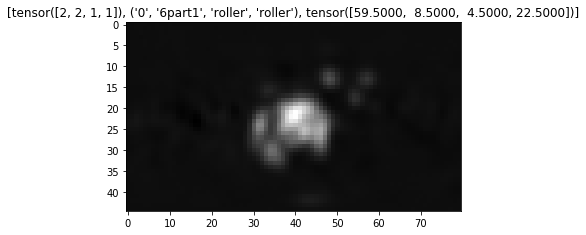

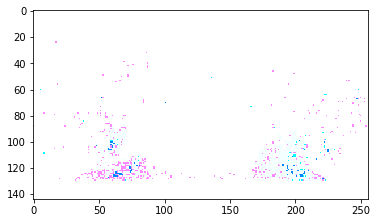

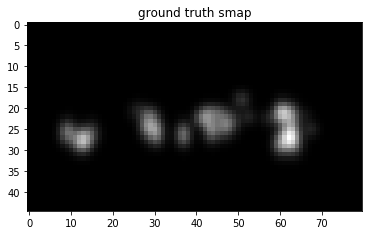

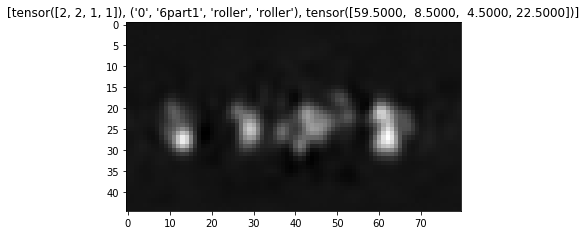

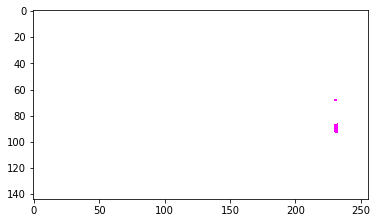

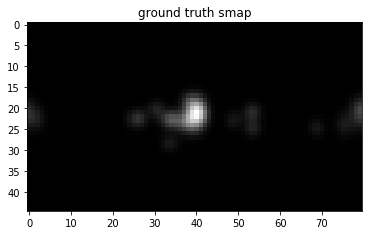

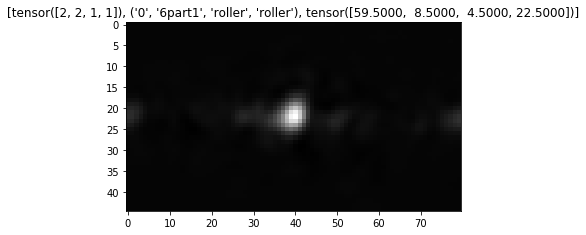

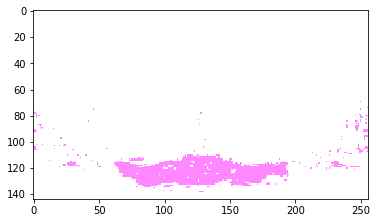

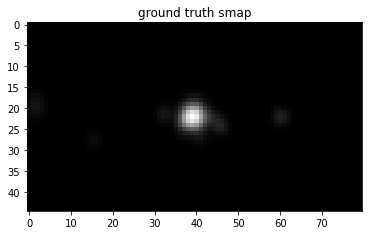

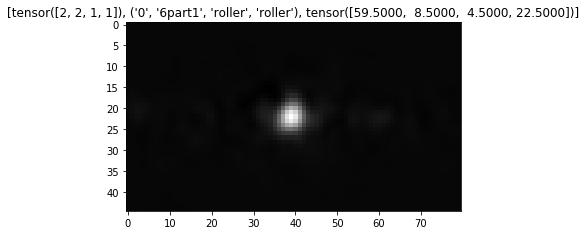

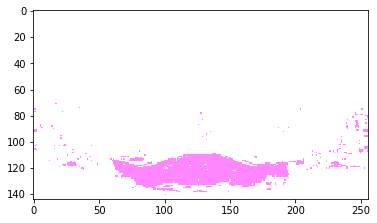

<Figure size 432x288 with 0 Axes>

In [52]:
#TEST the model performance
sal_test_filepath = '../hmd-observe-video-prediction/data/pano-saliency-merge/ds_dcnn_expdistance_test'
#sal_ds_filepath = './dataset/pano-saliency/ds_full'
#tf5 =  transform.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
test_transformed_dataset = saliency_predictor.PanoSalDataset(sal_test_filepath, transform=tv.transforms.Compose(transform_test))
testloader = t.utils.data.DataLoader(test_transformed_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

with t.no_grad():
    for i, (t0, img_list, label_list) in enumerate(testloader):
        for idx in range(BATCH_SIZE):
            img_list = img_list.type(t.FloatTensor).to(device)
            fx = resnet(img_list).view(-1, header_sal.TARGET_SAL_H, header_sal.TARGET_SAL_W)
            smap = fx[idx].data.cpu().numpy()
            
            img = img_list[idx].data.cpu().numpy().transpose(1, 2, 0)
            label = label_list[idx].data.cpu().numpy()
            plt.imshow(label, cmap='gray')
            plt.title('ground truth smap')
            plt.figure()
            plt.imshow(smap, cmap='gray')
            plt.title('predicted smap')
            plt.title(t0)
            plt.figure()    
            plt.imshow((img - img.min())/(img.max() - img.min()) * 255)
            plt.figure()
        break

In [54]:
#NOW, GENERATE PREDICTED SALIENCY MAPS
resnet = tv.models.resnet101(pretrained=True)
saliency_predictor.modify_fc_layers(resnet)
resnet.to(device)
#PATH = '../hmd-observe-video-prediction/models/panoresnet101_sal45x80merged_step002_expdistance_60_bk'
PATH = '../hmd-observe-video-prediction/models/panoresnet101_sal45x80merged_step002_expdistance_300'
resnet.load_state_dict(t.load(PATH, map_location=device))
#dat = pickle.load(open('../hmd-observe-video-prediction/data/pano-saliency-merge/ds_dcnn_expdistance_full', 'rb'))
sal_full_filepath = '../hmd-observe-video-prediction/data/pano-saliency-merge/ds_dcnn_expdistance_full'

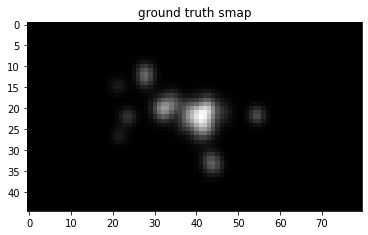

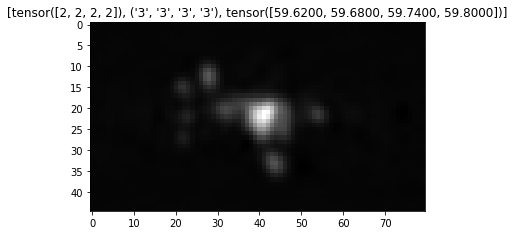

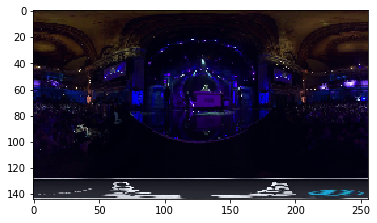

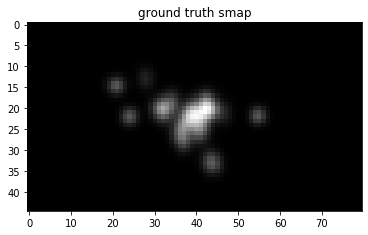

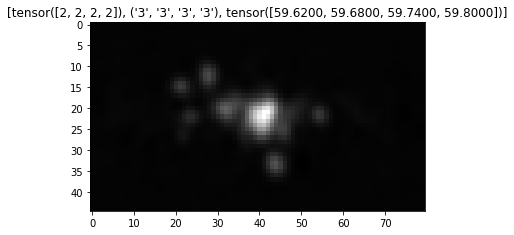

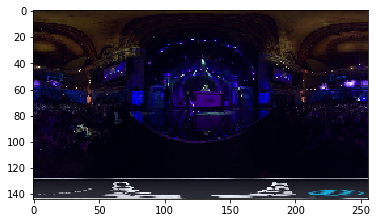

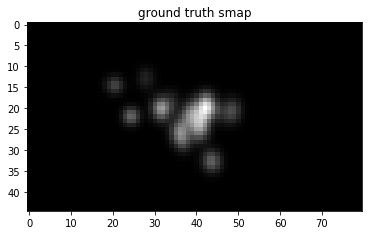

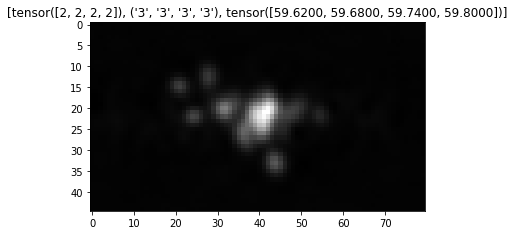

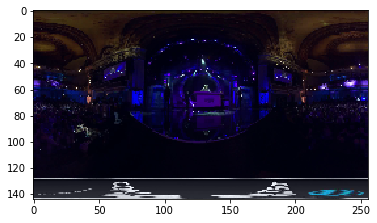

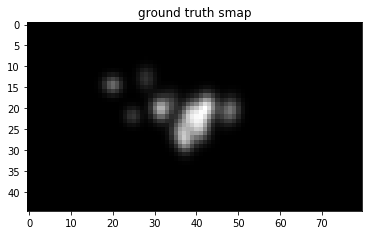

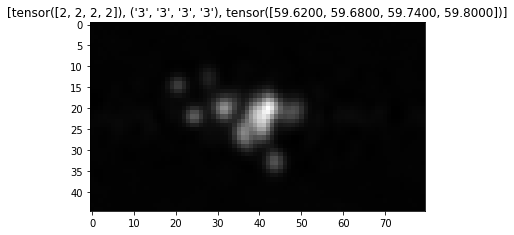

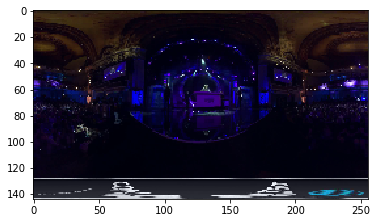

<Figure size 432x288 with 0 Axes>

In [60]:
#TEST IF MODEL WORKS OK ON FULL GEN SET
gen_transformed_dataset = saliency_predictor.PanoSalDataset(sal_full_filepath, transform=tv.transforms.Compose(transform_gen))
genloader = t.utils.data.DataLoader(gen_transformed_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

with t.no_grad():
    for i, (t0, img_list, label_list) in enumerate(genloader):
        if i < 2233 or i > 2243:
            continue
        img_list = img_list.type(t.FloatTensor).to(device)
        fx = resnet(img_list).view(-1, header_sal.TARGET_SAL_H, header_sal.TARGET_SAL_W)
        for idx in range(BATCH_SIZE):
            smap = fx[idx].data.cpu().numpy()
            img = img_list[idx].data.cpu().numpy().transpose(1, 2, 0)
            img = (((img - img.min())/(img.max() - img.min())) *  255).astype(int)
            label = label_list[idx].data.cpu().numpy()
            plt.imshow(label, cmap='gray')
            plt.title('ground truth smap')
            plt.figure()
            plt.imshow(smap, cmap='gray')
            plt.title('predicted smap')
            plt.title(t0)
            plt.figure()    
            plt.imshow(img)
            plt.figure()
        break

In [65]:
transformed_dataset = saliency_predictor.PanoSalDataset(sal_full_filepath, transform=tv.transforms.Compose(transform_gen))
eval_full_loader = t.utils.data.DataLoader(transformed_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=4)

tdict = header.topic_dict
tf_list = tv.transforms.Compose([tv.transforms.ToTensor(), tf5])
salpred_dict = {1:{}, 2:{}, 3:{}}
with t.no_grad():
    #for idx, ((ds, topic, t0), img, smap) in enumerate(dat):
    for idx, ((ds_list, topic_list, t0_list), img_list, label_list) in enumerate(eval_full_loader):
#         if idx < 2000: 
#                 continue
#         if idx > 2010:
#                 break                
#         print (idx)
        img_list = img_list.type(t.FloatTensor).to(device)
        fx_list = resnet(img_list).view(-1, header_sal.TARGET_SAL_H, header_sal.TARGET_SAL_W)

        
        for idx_item in range(len(img_list)):
            ds = ds_list[idx_item].cpu().item()
            topic = topic_list[idx_item]
            t0 = t0_list[idx_item].item()
            fx = fx_list[idx_item].data.cpu().numpy()
            
            img = img_list[idx_item].data.cpu().numpy().transpose(1, 2, 0)
            img = (((img - img.min())/(img.max() - img.min())) *  255).astype(int)
            label = label_list[idx_item].data.cpu().numpy()

            if topic not in salpred_dict[ds]:
                salpred_dict[ds][topic] = []
            salpred_dict[ds][topic].append((t0, -1, fx))
            
#             plt.imshow(img)
#             plt.figure()
#             plt.imshow(label)
#             plt.figure()
#             plt.imshow(fx, cmap='gray')
#             plt.figure()
            
            

In [66]:
for ds in tdict:
    for topic in tdict[ds]:
        print (f'Writting predicted saliency for ds:{ds} - topic:{topic} to file')
        filepath_name = f'../hmd-observe-video-prediction/data/pano-saliency-pred-expdistance/saliency_ds{ds}_topic{topic}'
        pickle.dump(salpred_dict[ds][topic], open(filepath_name, 'wb'))

Writting predicted saliency for ds:1 - topic:paris to file
Writting predicted saliency for ds:1 - topic:roller to file
Writting predicted saliency for ds:1 - topic:venise to file
Writting predicted saliency for ds:1 - topic:diving to file
Writting predicted saliency for ds:1 - topic:timelapse to file
Writting predicted saliency for ds:2 - topic:0 to file
Writting predicted saliency for ds:2 - topic:1 to file
Writting predicted saliency for ds:2 - topic:2 to file
Writting predicted saliency for ds:2 - topic:3 to file
Writting predicted saliency for ds:2 - topic:4 to file
Writting predicted saliency for ds:2 - topic:5part1 to file
Writting predicted saliency for ds:2 - topic:6part1 to file
Writting predicted saliency for ds:2 - topic:7 to file
Writting predicted saliency for ds:2 - topic:8 to file
Writting predicted saliency for ds:3 - topic:coaster2 to file
Writting predicted saliency for ds:3 - topic:diving2 to file
Writting predicted saliency for ds:3 - topic:drive to file
Writting pr

In [ ]:
#NOTE: currently using panoresnet101_sal45x80merged_step002_expdistance_60_bk to generate initial results
#NOW: try to improve saliency map and rerun the model

In [ ]:
ds_list, topic_list, len(img_list)